In [1]:
import pandas as pd
import numpy as np
import os 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from copy import deepcopy

base_path = '/Users/freezylex/Documents/course_work/'

# CDS 1Y

In [2]:
cds = pd.read_excel(os.path.join(base_path, 'data/raw_data/CDS RUSSIA 1Y RAW.xlsx'))
cds = cds[['Date', 'cds_1y']]
cds = cds[~cds['cds_1y'].isin([' '])] #Without empty rows
cds.columns = ['Date', 'CDS1Y']
cds['Date'] = pd.to_datetime(cds['Date'], format = '%Y-%m-%d')
cds = cds[::-1].reset_index(drop=True)
cds.set_index('Date', inplace=True)
cds['CDS1Y'] = cds['CDS1Y'].astype('float')
cds.head(2)

,CDS1Y
Date,
2015-03-02,458.62
2015-03-03,450.32


In [3]:
cds_train, cds_test = cds.loc['2015-06-01': '2016-01'].reset_index(), cds.loc['2016-02'].reset_index()

#### Upload target

In [4]:
rates = pd.read_excel(base_path + 'data/final_target.xlsx',
                      index_col = 'Date', parse_dates=True)
rates.drop(columns=['SU26217RMFS', 'SU26218RMFS'], inplace=True)
rates.head(2)

,SU26214RMFS,SU26215RMFS,SU26216RMFS,SU26203RMFS,SU26204RMFS,SU26205RMFS,SU26206RMFS,SU26207RMFS,SU26208RMFS,SU26209RMFS,SU26210RMFS,SU26211RMFS,SU26212RMFS
Date,,,,,,,,,,,,,
2015-03-02,-71.009402,-16.198293,-51.672678,213.214039,8.877833,-69.514138,81.363229,81.611366,-44.294101,-46.555882,-65.581271,-32.632524,103.025743
2015-03-03,7.255880,45.041981,17.967756,263.188637,62.406383,10.363783,125.481830,112.795674,22.874165,26.012453,9.625523,34.752162,129.932953


In [5]:
df = rates.reset_index().merge(cds.reset_index(), on='Date', how='inner') #Join for future graphs
df.set_index('Date', inplace=True)
df_train, df_test = df.loc['2015-06-01': '2016-01'].reset_index(), df.loc['2016-02'].reset_index()

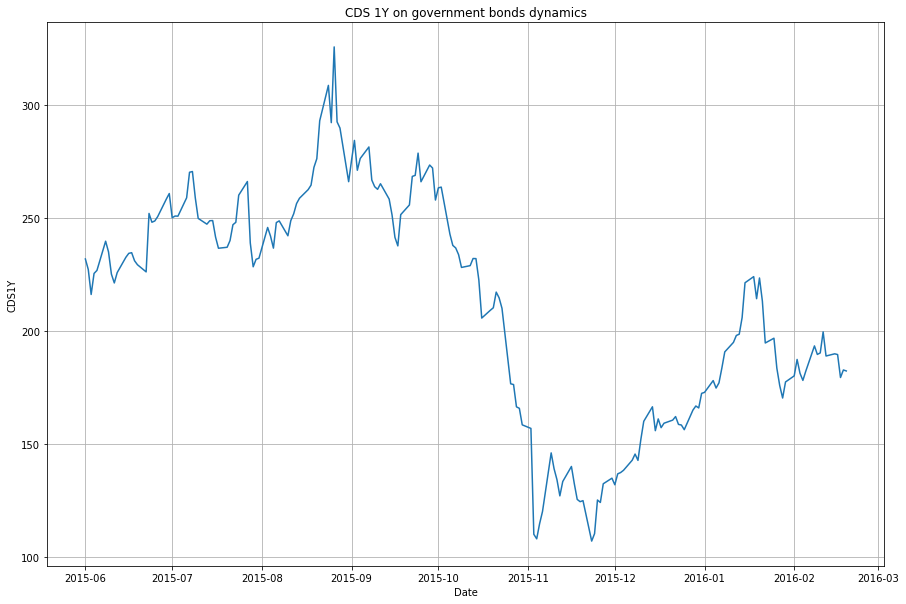

In [6]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(x = cds.loc['2015-06':].index,
             y = cds['CDS1Y'].loc['2015-06':])
plt.title('CDS 1Y on government bonds dynamics')
plt.grid()
plt.savefig(os.path.join(base_path, 'graphs/CDS.png'), dpi=300)
plt.show()

- It can be seen that in October a structural break also happened. It will be easier to notice on the following graph
- Some spike also happened in 2016-01. It is also connected with the fall of the russian ruble and oil prices, just as the RVI index. But currently it is not the main aspect of the research, since that change was already taken into account by dummy variable in the RVI index

In [42]:
def make_plot_for_gen(df, factor, factor_col, hue_date=None):
    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    min_ = df.values.ravel().min()
    max_ = df.values.ravel().max()
    if hue_date:
        h = pd.Series(index = factor.index, data = np.zeros(shape=factor.shape[0]))
        h.loc[hue_date:] = 1
        print(h)
    else:
        h = None
    i = 0
    for col in ['SU26203RMFS', 'SU26214RMFS', 'SU26207RMFS']:
        sns.scatterplot(x = factor[factor_col],y = df[col], ax = ax[i], hue = h, palette='deep')
        ax[i].set_ylim([min_ - 0.1, max_ + 0.1])
        ax[i].set_xlabel('CDS 1Y contract price', fontsize=15)
        ax[i].set_ylabel(f'OFZ {col[2:-4]}', fontsize=15)
        ax[i].tick_params(axis='both', labelsize=15)
        ax[i].legend(prop=dict(size=18))
        i += 1
    plt.savefig(os.path.join(base_path, 'graphs/CDS_scatter.png'),dpi=300)

Date
2015-06-01    0.0
2015-06-02    0.0
2015-06-03    0.0
2015-06-04    0.0
2015-06-05    0.0
             ... 
2016-01-25    1.0
2016-01-26    1.0
2016-01-27    1.0
2016-01-28    1.0
2016-01-29    1.0
Length: 175, dtype: float64


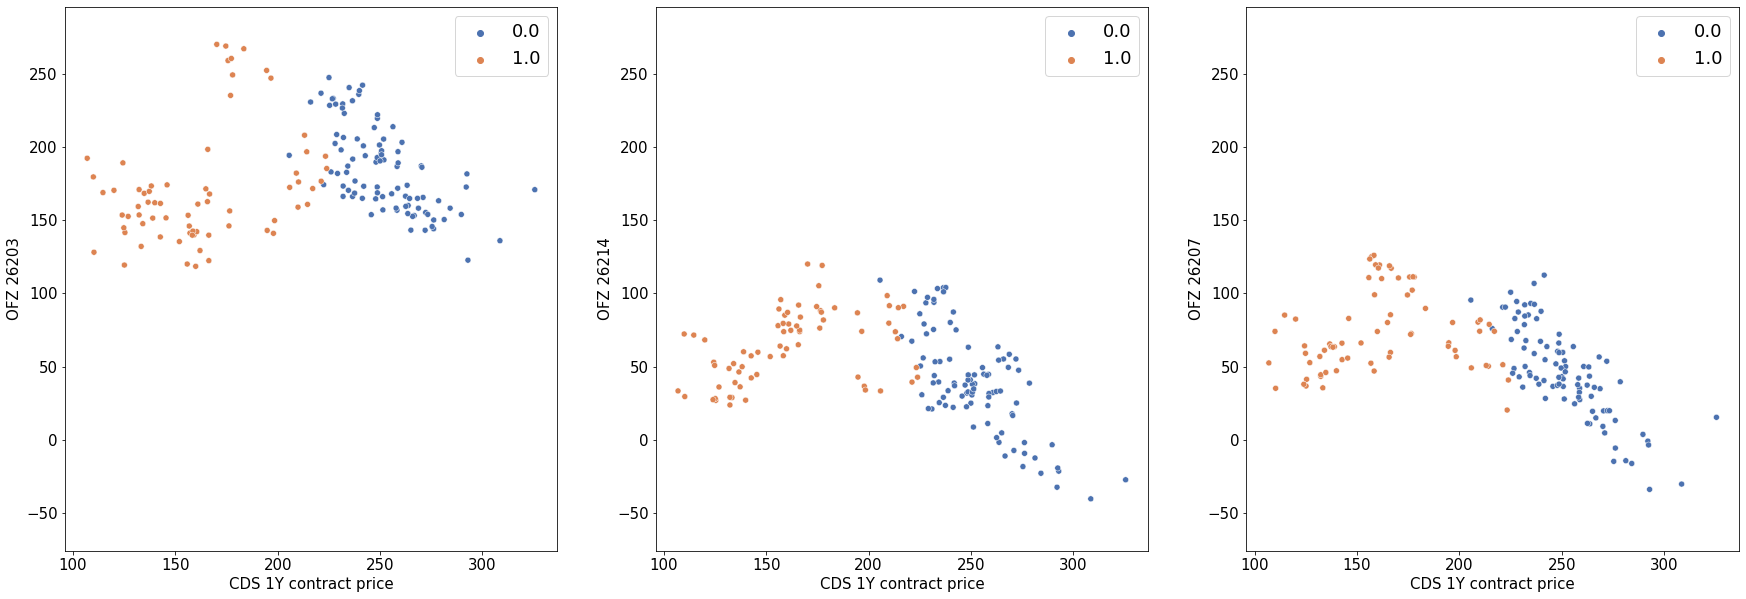

In [43]:
make_plot_for_gen(rates, cds.loc['2015-06-01':'2016-01'], 'CDS1Y','2015-10-19')

- The first period can be characterized by the positive sign of the slope (bright points): the increase in CDS value is followed by an increase in the target variable
- The second part, however, since 2015-10-19 (as it was found out) is best described by the negative sign of the slope (dark points): increase in CDS value leads to decrease of the target variable.
- Obviously, some external news happened that influence the dependencies of the variables.
------------
- In late Friday 16, October there was confirmed Russia's rating: Russia's long-term credit rating in foreign currency was affirmed by Standard & Poor's at "BB+" (negative outlook), while the short-term rating in national currency remained at investment level. Fitch also affirmed Russia's rating at "BBB-" (negative outlook).
https://rg.ru/2015/10/17/reiting-site-anons.html?utm_source=yxnews&utm_medium=desktop&utm_referrer=https%3A%2F%2Fyandex.ru%2Fnews%2Fsearch%3Ftext%3D 
- Since the news did not influence Friday trading session, we will put a marker on the 19th of October.
-------
- Later on it was also stated that sanction pressure was getting lower - stated by Fitch: https://versia.ru/yeksperty-rejtingovogo-agentstva-fitch-konstatirovali-snizhenie-riska-uzhestocheniya-sankcij-protiv-rossii?utm_source=yxnews&utm_medium=desktop&utm_referrer=https%3A%2F%2Fyandex.ru%2Fnews%2Fsearch%3Ftext%3D
- The US also stated about the possibility of lifting of sanctions: https://www.gazeta.ru/business/news/2015/10/30/n_7830917.shtml?utm_source=yxnews&utm_medium=desktop&utm_referrer=https%3A%2F%2Fyandex.ru%2Fnews%2Fsearch%3Ftext%3D

In [9]:
cds['CDS_struct_coef'] = 0
cds['CDS_dummy_struct'] = 0
cds.loc['2015-10-19':].loc[:, 'CDS_struct_coef'] = 1
cds.loc['2015-10-19':].loc[:, 'CDS_dummy_struct'] = 1
cds['CDS_struct_coef'] = cds['CDS_dummy_struct'] * cds['CDS1Y']
cds.tail(2)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,CDS1Y,CDS_struct_coef,CDS_dummy_struct
Date,,,
2016-02-18,182.675,182.675,1
2016-02-19,182.245,182.245,1


In [10]:
cds.head(2)

,CDS1Y,CDS_struct_coef,CDS_dummy_struct
Date,,,
2015-03-02,458.62,0.0,0
2015-03-03,450.32,0.0,0


In [11]:
cds.to_csv(os.path.join(base_path, 'data/metrics_final/cds.csv'))

## Additional research

- Same approach as in the RVI variable

In [12]:
dict_with_coefs = {}
min_num_ob = 10
for bond in rates.columns:
    x = df['CDS1Y'].values
    y = df[bond].values
    coefs = []
    for i in range(min_num_ob, len(x)): #at least 10 observations for regression
        model = LinearRegression()
        model.fit(x[:i].reshape((-1, 1)),
                  y[:i].reshape((-1, 1)))
        coefs.append(model.coef_[0][0])
    dict_with_coefs[bond] = coefs
coefs_df = pd.DataFrame(dict_with_coefs, index = df.index[min_num_ob:])

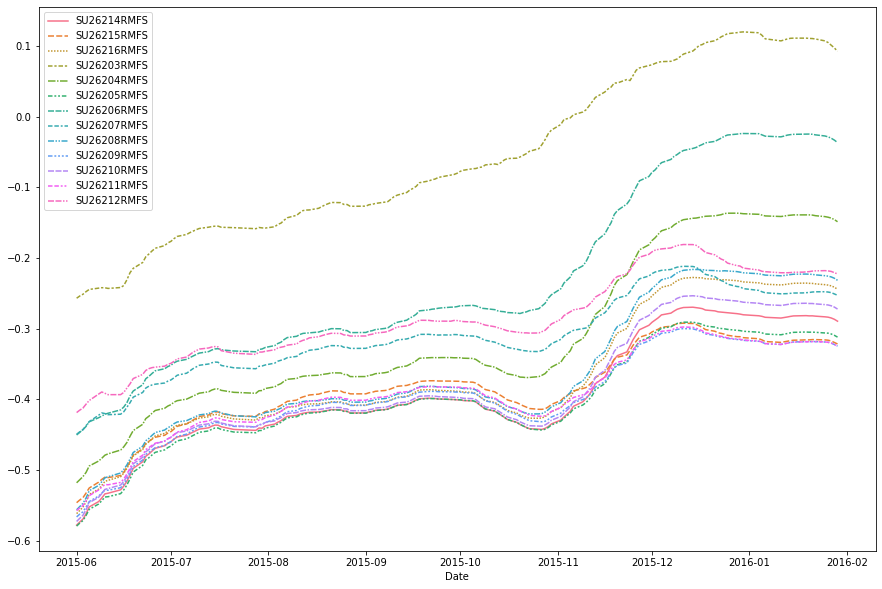

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data = coefs_df.loc['2015-06-01':'2016-01'])
plt.show()

- We can se a change in the coefficients exactly in October. We assume, however, that floating window will be better in this case, since the sign of the slope changed

In [14]:
window = 45
dict_with_coefs = {}
for bond in rates.columns:
    x = df['CDS1Y'].values
    y = df[bond].values
    coefs = []
    for i in range(window, len(x)): #at least 5 observations for regression
        model = LinearRegression()
        model.fit(x[i-window:i].reshape((-1, 1)),
                  y[i-window:i].reshape((-1, 1)))
        coefs.append(model.coef_[0][0])
    dict_with_coefs[bond] = coefs
coefs_df = pd.DataFrame(dict_with_coefs, index = df.index[window:])

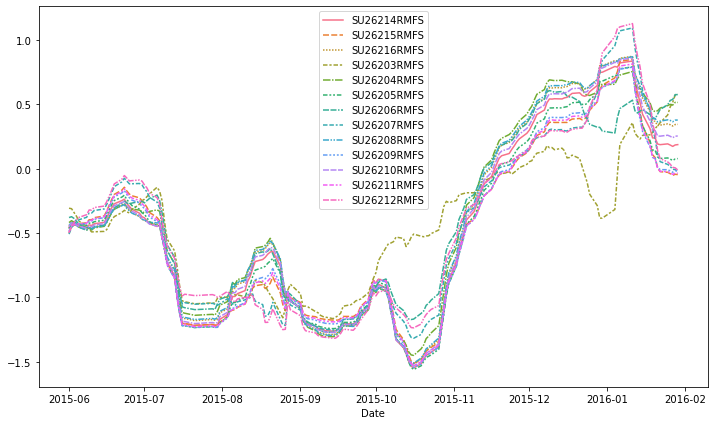

In [15]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(data = coefs_df.loc['2015-06-01':'2016-01'])
plt.show()

 - Transition from positive to negative is clearly observable!

### QLR statistic

- Prove the break in October, 2015
- Indexes from 80 till 130

In [16]:
from chow_test import chow_test
bond = 'SU26203RMFS'
indexes = np.arange(80, 120).astype('int')
stats_f = []
p_vals = []
datee = []
for ind in indexes:
    res = chow_test(df_train['CDS1Y'], df_train[bond], int(ind), int(ind), significance = 0.01) #Test at 1% significance
    stats_f.append(res[0])
    p_vals.append(res[1])
    datee.append(df_train.loc[int(ind)]['Date'])
    

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 30.511857180832486, P_value: 6.091793736118234e-12
Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 31.270905694987828, P_value: 3.5265124154193472e-12
Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 32.16931500346841, P_value: 1.8554047187535616e-12
Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 34.15380445540838, P_value: 4.574118861455645e-13
Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 34.1544687758834, P_value: 4.571898415406395e-13
Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 33.94249285331983, P_value: 5.302425165609748e-13
Reject the null hypothesis of equality of regression coefficients in the two periods.

In [17]:
ct_info = pd.DataFrame(np.vstack((indexes, stats_f, p_vals, datee)).T, columns = ['index_number',
                                                                'Chow_stat', 'P_val', 'Date'])
ct_info.sort_values(by = 'Chow_stat', ascending=False).head(15)

,index_number,Chow_stat,P_val,Date
4,84,34.154469,0.0,2015-10-06
3,83,34.153804,0.0,2015-10-05
5,85,33.942493,0.0,2015-10-07
6,86,33.885525,0.0,2015-10-08
7,87,33.22394,0.0,2015-10-09
9,89,32.965138,0.0,2015-10-13
8,88,32.754003,0.0,2015-10-12
10,90,32.363465,0.0,2015-10-14
2,82,32.169315,0.0,2015-10-02
11,91,31.860489,0.0,2015-10-15


- We can see that the transition, based on the test, happened even earlier. This might be connected with the fact that invectors expectations were forming gradually.

## Stationarity check

In [13]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

In [20]:
cds = cds.loc['2015-06-01':]
cds

,CDS1Y
Date,
2015-06-01,231.760
2015-06-02,227.120
2015-06-03,216.060
2015-06-04,225.360
2015-06-05,226.700
...,...
2016-02-15,189.820
2016-02-16,189.495
2016-02-17,179.340


In [22]:
print(f'P-value for CDS time-series, ADF test, const: {np.round(adfuller(cds["CDS1Y"], regression="c", autolag="AIC")[1], 3)}')
print(f'P-value for CDS time-series, KPSS test, const: {kpss(cds["CDS1Y"], regression="c")[1]}')
print()
print(f'P-value for CDS time-series, ADF test, const + trend : {np.round(adfuller(cds["CDS1Y"], regression="ct", autolag="AIC")[1], 3)}')
print(f'P-value for CDS time-series, KPSS test, const + trend: {kpss(cds["CDS1Y"], regression="ct")[1]}')


P-value for CDS time-series, ADF test, const: 0.627
P-value for CDS time-series, KPSS test, const: 0.012577519007172543

P-value for CDS time-series, ADF test, const + trend : 0.707
P-value for CDS time-series, KPSS test, const + trend: 0.06625050531217833


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


## Cointegration test

In [20]:
from statsmodels.tsa.stattools import coint

In [21]:
p_vals_coint_test = [] #H0 - no cointegration
p_vals_coint_test_ct = []
for bond in rates.columns:
    p_vals_coint_test.append(coint(df_train[bond].values, df_train['CDS1Y'].values, trend='c')[1])
    p_vals_coint_test_ct.append(coint(df_train[bond].values, df_train['CDS1Y'].values, trend='ct')[1])
res_ts = pd.DataFrame(zip(p_vals_coint_test, p_vals_coint_test_ct), index = rates.columns, 
                      columns=['Cointegration test p-val, const', 'Cointegration test p-val, const + trend'])
res_ts.sort_index()

,"Cointegration test p-val, const","Cointegration test p-val, const + trend"
SU26203RMFS,0.078473,0.307148
SU26204RMFS,0.380761,0.617358
SU26205RMFS,0.265414,0.406327
SU26206RMFS,0.376335,0.767408
SU26207RMFS,0.055995,0.140984
SU26208RMFS,0.415271,0.562454
SU26209RMFS,0.219913,0.360141
SU26210RMFS,0.338835,0.468435
SU26211RMFS,0.204956,0.340860
SU26212RMFS,0.101038,0.244910


- No cointegration